#  Описание данных.

Компания «Чётенькое такси» предоставила нам исторические данные о заказах такси в аэропортах для того, чтобы привлекать больше водителей в период пиковой нагрузки. Наша задачей в данном проекте - спрогнозировать количество заказов такси на следующий час.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Нам необходимо:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_squared_error
import time
from sklearn.model_selection import cross_val_score

In [2]:
df = pd.read_csv('/datasets/taxi.csv')

In [3]:
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [5]:
df['datetime'] = pd.to_datetime(df['datetime'])

df = df.set_index('datetime').sort_index()

df = df.resample('1H').sum()

In [6]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


**Промежуточный вывод:**<br>По первому взгляду стоит сказать, что с данными все в порядке. Пропущенных значений не обнаружено.<br>Единственное, что мы сделали - поменяли тип данных у столбца 'datetime' и выполнили ресемплирование по часам.

## Анализ

### Тренды и сезонность

In [7]:
fs = (10,7)
def trend_seasons(df, date):
    fig, axes = plt.subplots(2, 1, figsize=fs)
    decomposed_df = seasonal_decompose(df)
    decomposed_df.trend.plot(ax=axes[0], title='Trend')
    axes[0].set_ylabel('Количество заказов')
    axes[0].set_xlabel(date)
    decomposed_df.seasonal.plot(ax=axes[1], title='Seasonal')
    axes[1].set_ylabel('Количество заказов')
    axes[1].set_xlabel(date)
    
    plt.tight_layout()
    plt.show()

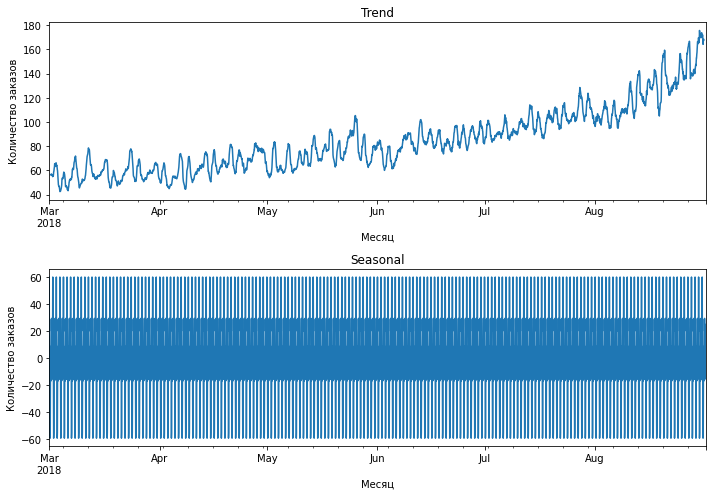

In [8]:
trend_seasons(df, 'Месяц')

Рассмотрим теперь тренд и сезонность за последний месяц.

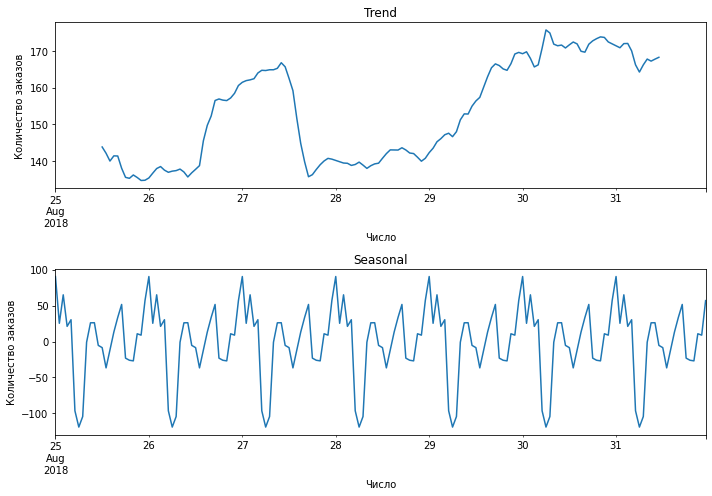

In [9]:
df_week_1 = df['2018-08-25':'2018-08-31']
trend_seasons(df_week_1, 'Число')

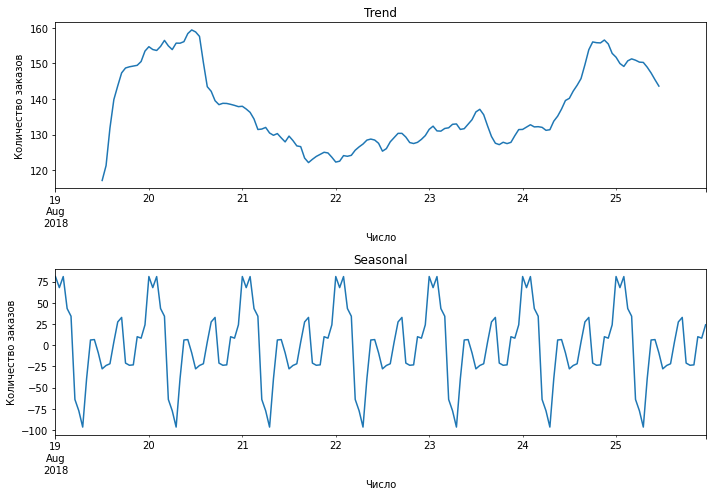

In [10]:
df_week_2 = df['2018-08-19':'2018-08-25']
trend_seasons(df_week_2, 'Число')

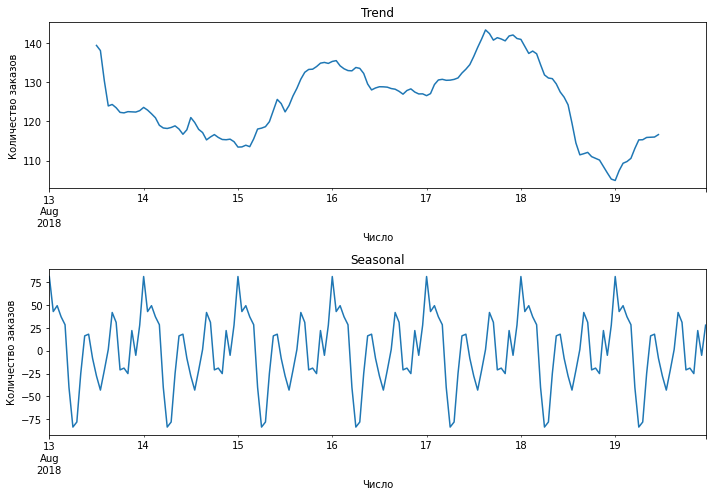

In [11]:
df_week_3 = df['2018-08-13':'2018-08-19']
trend_seasons(df_week_3, 'Число')

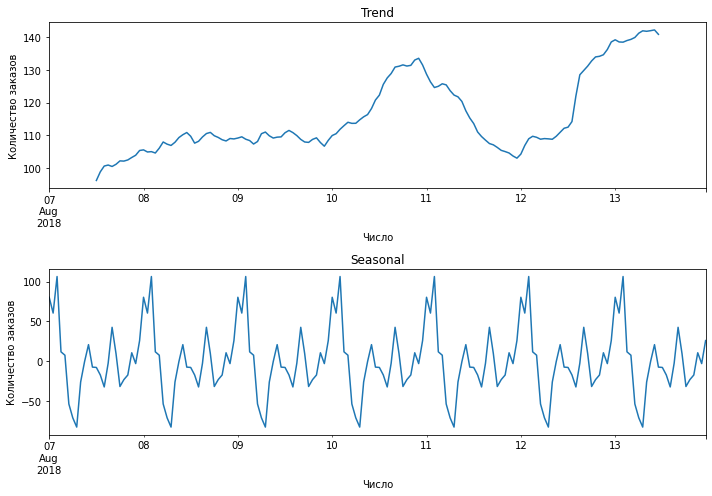

In [12]:
df_week_4 = df['2018-08-7':'2018-08-13']
trend_seasons(df_week_4, 'Число')

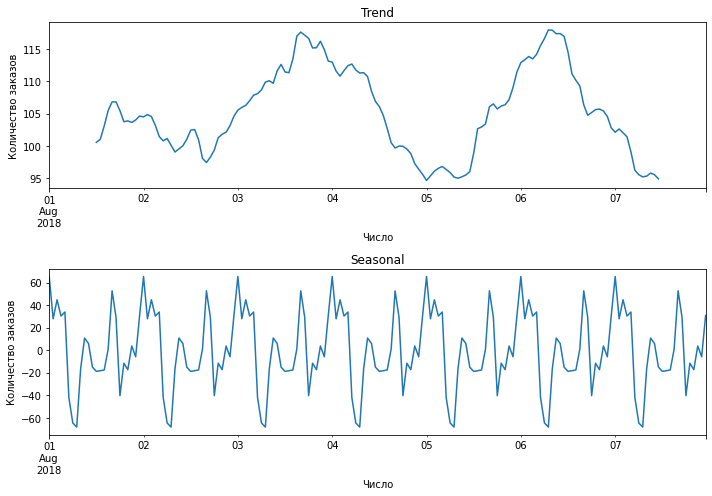

In [13]:
df_week_5 = df['2018-08-1':'2018-08-7']
trend_seasons(df_week_5, 'Число')

C сезонностью все стабильно. Наблюдается суточная сезонность. Заказы достигают минимума в ночное время, затем возрастают с утра и в течение дня, достигая пика к вечеру. Природа сезонности часовая, так как наблюдается общий тренд равномерного роста количества заказов. Это может указывать на то, что летом люди больше путешествуют, а значит и пользуются аэропортами.

### Стационарность

In [14]:
df["rolling_mean"] = df["num_orders"].rolling(20, closed='left').mean()
df["rolling_std"] = df["num_orders"].rolling(20, closed='left').std()

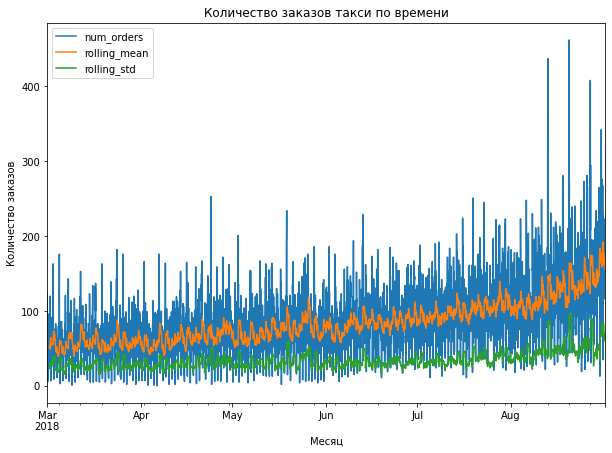

In [15]:
df.plot(figsize=fs)
plt.title('Количество заказов такси по времени')
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.show()

На данном этапе смею предположить, что данные выглядят нестационарно, ввиду того, что наблюдается рост.

Проведем ADF-test и посмотрим, что он нам 'скажет'.<br>**Нулевая гипотеза (H0):** Ряд имеет единичный корень (нестационарный).<br>**Альтернативная гипотеза (H1):** Ряд не имеет единичного корня (стационарный).

In [16]:
ts = df['num_orders']
st_test = adfuller(ts, regression='ctt')

if st_test[1] < 0.01:
    print('Ряд стационарный')
else:
    print('Ряд нестационарный')

Ряд стационарный


Согласно тесту Дики-Фуллера, мы убедились, что ряд - стационарный. 

**Промежуточный вывод:**<br>Если брать общую картину, то:<br>- заказы достигают минимума в ночное время, затем возрастают с утра и в течение дня, достигая пика к вечеру;<br>- присутствует общий тренд равномерного роста количества заказов, что может указывать на то, что к лету/летом количество заказов в аэрапортах увеличивается;<br>- ряд стационарен.<br>Все вышеперчисленное означает, что мы можем приступить к следующему шагу.

## Обучение

### Подготовка

Прежде чем начинать обучение, считаю необходимым привести датасет к красивому виду, а именно:<br>Избавиться от лишних столбцов и разбить столбец datetime на более конкретные столбцы (month, day, day_of_week,time)

In [17]:
df = df.drop(columns=['rolling_mean', 'rolling_std'], axis = 1)

In [18]:
def make_features(df):
    df = df.copy()
    #df['month'] = df.index.month
    df['day'] = df.index.day
    df['day_of_week'] = df.index.dayofweek
    df['hour'] = df.index.hour
    
    for i in range(1, 6):
        df['lag_{}'.format(i)] = df['num_orders'].shift(i)
    
    df['rolling_mean'] = df['num_orders'].shift().rolling(1).mean()
    df.dropna(inplace=True)
    
    return df

In [19]:
df = make_features(df)

Разделим данные. Целевой признак - число заказов.

In [20]:
RANDOM_STATE=42
TEST_SIZE=0.1

X = df.drop(['num_orders'], axis=1)
y = df['num_orders']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    shuffle=False
)

### Поиск лучшей модели

Для поиска лучшей модели с лучшими гиперпараметрами, будем использовать Pipeline.

In [22]:
num_columns = ['day', 'day_of_week', 'hour', 
               'lag_1', 'lag_2','lag_3', 'lag_4', 'lag_5', 'rolling_mean']

In [23]:
data_preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_columns)
], remainder='passthrough')

In [24]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

In [25]:
param_grid = [
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'models__max_depth': range(2, 10),
        'models__max_features': range(2, 10)
    },
    {
        'models': [RandomForestRegressor(random_state=RANDOM_STATE)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'models__n_estimators': [50, 100, 200, 300],
        'models__max_depth': range(5, 15),
        'models__max_features': [2, 3, 'auto', None]
    },
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'models__normalize': [True, False]
    },
    {
        'models': [LGBMRegressor(random_state=RANDOM_STATE)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'models__num_leaves': [20, 30, 40, 50],
        'models__max_depth': range(5, 20)
    },
    {
        'models': [CatBoostRegressor(random_state=RANDOM_STATE, verbose=0)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'models__depth': [4, 6, 8, 10],
        'models__iterations': [100, 200, 300, 400]
    }
]



pipe_final.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['day', 'day_of_week', 'hour',
                                                   'lag_1', 'lag_2', 'lag_3',
                                                   'lag_4', 'lag_5',
                                                   'rolling_mean'])])),
                ('models', DecisionTreeRegressor(random_state=42))])

In [26]:
rmse_scorer = make_scorer(mean_squared_error, squared=False, greater_is_better=False)

In [27]:
time_series_split = TimeSeriesSplit()

random_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=time_series_split,
    scoring=rmse_scorer,
    n_jobs=-1,
    random_state=RANDOM_STATE
)

In [28]:
random_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', random_search.best_estimator_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['day', 'day_of_week', 'hour',
                                                   'lag_1', 'lag_2', 'lag_3',
                                                   'lag_4', 'lag_5',
                                                   'rolling_mean'])])),
                ('models',
                 <catboost.core.CatBoostRegressor object at 0x7f1ca96a79a0>)])


Как мы можем видеть, лучшей оказалась модель - CatBoostRegressor.

### Обучение лучшей модели

In [29]:
model = random_search.best_estimator_

In [30]:
rmse_value = -random_search.best_score_
print('Метрика RMSE лучшей модели на тренировочной выборке:', rmse_value)

Метрика RMSE лучшей модели на тренировочной выборке: 26.963821831603823


In [31]:
start_time = time.time()
model.fit(X_train, y_train)
end_time = time.time()
train_time = round((end_time - start_time), 5)
print("Время обучения: %s секунд" % train_time)

start_time = time.time()
model.predict(X_train)
end_time = time.time()
predict_time = round((end_time - start_time), 5)
print("Время предсказания: %s секунд" % predict_time)

Время обучения: 0.78202 секунд
Время предсказания: 0.00538 секунд


**Промежуточный вывод:**<br>Мы нашли лучшую модель, а именно CatBoostRegressor.<br>Затем, использовав ее, обучили данные. Они обучились достаточно хорошо и быстро. Метрика RMSE показала неплохое значение на тренировачной выборке, поэтому пришло время проверить модель на тестовых данных.

## Тестирование

In [32]:
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Метрика RMSE лучшей модели на тестовой выборке:', round(rmse, 2))

Метрика RMSE лучшей модели на тестовой выборке: 47.46


**Промежуточный вывод:**<br>Метрика RMSE получилась менее 48, а значит наша модель работает корректно.

## Общий вывод

После тщательного анализа данных о заказах такси в аэропортах и обучения различных моделей для прогнозирования количества заказов на следующий час, сделаем некоторые выводы:<br>Мы изучили исторические данные о заказах такси и выявили сильную суточную и недельную сезонность, а также общий тренд к росту количества заказов к летнему сезону. Данные были ресемплированы по часам и оценены как стационарные.<br>Мы протестировали несколько моделей, включая решающие деревья, случайный лес, линейную регрессию, градиентный бустинг и библиотеки CatBoost и LightGBM. Лучшей моделью оказался CatBoostRegressor.<br>После обучения модели на тренировочной выборке мы проверили ее на тестовой выборке. Метрика RMSE на тестовой выборке составила менее 48, что соответствует нашим требованиям. Это означает, что наша модель успешно способна прогнозировать количество заказов такси на следующий час.<br>На основании проведенного исследования можно с уверенностью сказать, что разработанная модель может быть эффективным инструментом для прогнозирования спроса на такси в аэропортах. Это позволит компании оптимизировать распределение ресурсов и повысить качество обслуживания клиентов в периоды пиковой нагрузки.